In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sgp4.api import Satrec, jday
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score


In [2]:
negative_label_files = ['active-sate.txt']
positive_label_files = ['cosmos-1408-debris.txt','cosmos-2251-debris.txt','fengyun-1c-debris.txt','iridium-33-debris.txt']
test_files = ['iridium-33-debris.txt']

In [3]:
earth_radius = 6371  # in km
mu = 398600.4418     # Earth's gravitational parameter in km^3/s^2
def parse_tle_file(tle_file_path, label):
    data = []
    labels = []
    fp = f'data/{tle_file_path}'
    with open(fp, 'r') as file:
        lines = file.readlines()
        for i in range(0, len(lines), 3):
            if i + 2 >= len(lines):  # Ensure we have both lines
                break

            line1 = lines[i+1].strip()
            line2 = lines[i + 2].strip()
            satellite = Satrec.twoline2rv(line1, line2)
            sat_id = line1[2:7].strip()
            eccentricity = satellite.ecco
            inclination = satellite.inclo
            raan = satellite.nodeo
            arg_perigee = satellite.argpo
            mean_anomaly = satellite.mo
            mean_motion = satellite.no_kozai
            semi_major_axis = 6378.1 / (1 - satellite.ecco)
            altitude = semi_major_axis - earth_radius
            perigee = semi_major_axis * (1 - eccentricity)
            apogee = semi_major_axis * (1+eccentricity)
            orbital_period = 86400/mean_motion
            
            jd, fr = jday(datetime.utcnow().year, datetime.utcnow().month, datetime.utcnow().day,
                          datetime.utcnow().hour, datetime.utcnow().minute, datetime.utcnow().second)

            e, r, v = satellite.sgp4(jd, fr)
            # print("position", r)
            # print("vel", v)
            # print("err", e)
            distance_from_center = np.sqrt(r[0]**2 + r[1]**2 + r[2]**2)
            velocity_magnitude = np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)
            specific_orbital_energy = (velocity_magnitude**2)/2 - (mu/distance_from_center)
            data.append({
                #'sat_id': sat_id,
                'eccentricity': eccentricity,
                'inclination': inclination,
                'raan': raan,
                'arg_perigee': arg_perigee,
                'mean_anomaly': mean_anomaly,
                'mean_motion': mean_motion,
                'semi_major_axis': semi_major_axis,
                'x': r[0],
                'y': r[1],
                'z': r[2],
                'vx': v[0],
                'vy': v[1],
                'vz': v[2],
                'altitude': altitude,
                'perigee': perigee,
                'apogee': apogee,
                'orbital_period': orbital_period,
                'distance_from_center': distance_from_center,
                'specific_orbital_energy': specific_orbital_energy,
                'velocity_magnitude': velocity_magnitude,
                'label':label
            })
            labels.append(label)
    return data, labels

In [4]:
from sgp4.api import accelerated
print(accelerated)
from sgp4.earth_gravity import wgs72
from sgp4.io import twoline2rv

with open('data/cosmos-1408-debris.txt', 'r') as file:
    lines = file.readlines()
    count = 0
    for i in range(0, len(lines), 3):
        if i + 2 >= len(lines):  # Ensure we have both lines
            break
        # if count > 1:
        #     break

        s = lines[i+1].strip()
        t = lines[i + 2].strip()
        assert twoline2rv(s, t, wgs72)
        count += 1

True


In [5]:
allrows = []
alllabels = []
count_of_positive = 0
count_of_negative = 0
for file_path in positive_label_files:
    d, l = parse_tle_file(file_path, 1)
    allrows.extend(d)
    alllabels.extend(l)
    count_of_positive += len(d)
for file_path in negative_label_files:
    d, l = parse_tle_file(file_path, 0)
    allrows.extend(d)
    alllabels.extend(l)
    count_of_negative += len(d)

print("count_of_positive", count_of_positive)
print("count_of_negative", count_of_negative)



/var/folders/qd/v5ry5_cj447fbwhs1jj9bgqh0000gn/T/ipykernel_85567/1884770284.py:29: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  jd, fr = jday(datetime.utcnow().year, datetime.utcnow().month, datetime.utcnow().day,
/var/folders/qd/v5ry5_cj447fbwhs1jj9bgqh0000gn/T/ipykernel_85567/1884770284.py:30: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  datetime.utcnow().hour, datetime.utcnow().minute, datetime.utcnow().second)


count_of_positive 2773
count_of_negative 10399


In [6]:
df = pd.DataFrame(allrows)
labelS = pd.Series(alllabels)
print("df", df.describe())
print("labels", labelS.shape)

df        eccentricity   inclination          raan   arg_perigee  mean_anomaly  \
count  13172.000000  13172.000000  13172.000000  13172.000000  13172.000000   
mean       0.005168      1.159968      2.979907      2.872730      3.365631   
std        0.039818      0.457430      1.942240      1.678268      1.700785   
min        0.000004      0.000033      0.000466      0.000698      0.000635   
25%        0.000138      0.925937      1.258809      1.528431      1.633657   
50%        0.000202      0.928822      2.812535      2.094934      4.062852   
75%        0.001337      1.700641      4.780007      4.635867      4.748073   
max        0.894166      2.673235      6.282941      6.282531      6.282587   

        mean_motion  semi_major_axis              x              y  \
count  13172.000000     13172.000000   13172.000000   13172.000000   
mean       0.061114      6461.183811     344.165525      60.145148   
std        0.014198      1418.147158    8049.360020    7804.563255   
min  

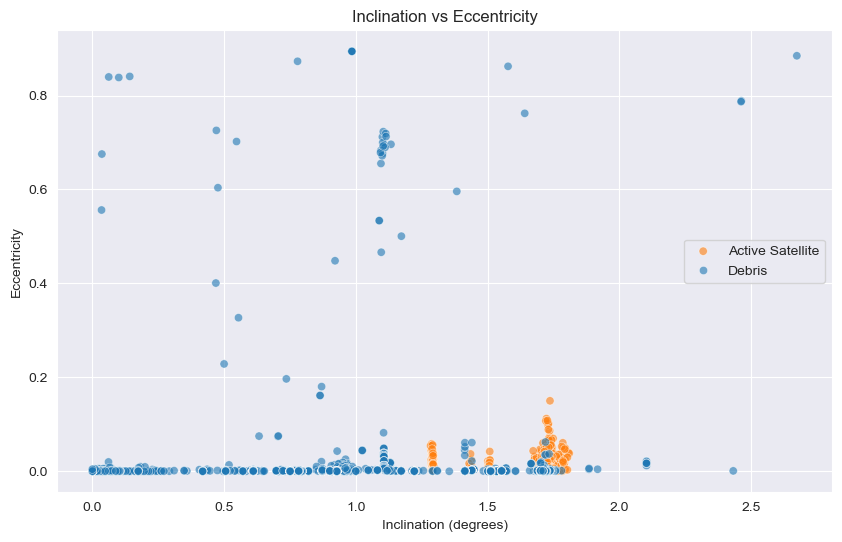

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='inclination', y='eccentricity', hue='label', alpha=0.6)
plt.title("Inclination vs Eccentricity")
plt.xlabel("Inclination (degrees)")
plt.ylabel("Eccentricity")
plt.legend(['Active Satellite', 'Debris'])
plt.show()

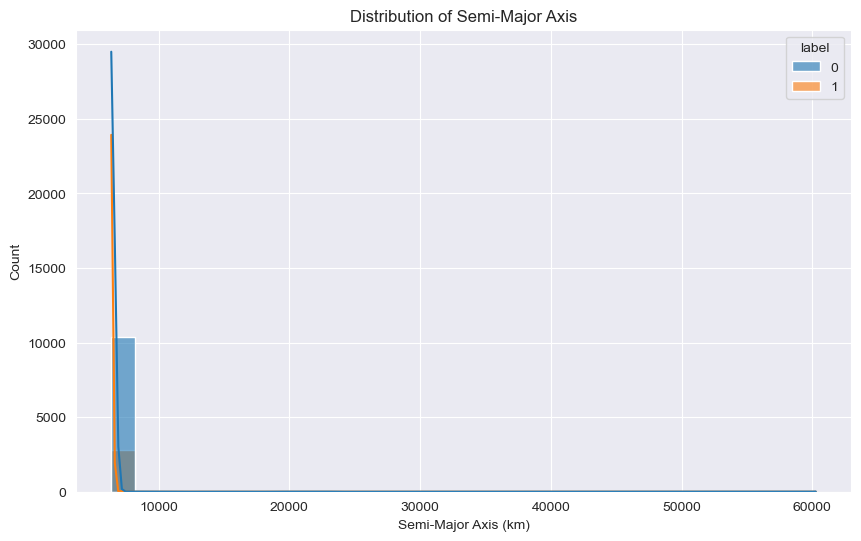

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='semi_major_axis', hue='label', kde=True, bins=30, alpha=0.6)
plt.title("Distribution of Semi-Major Axis")
plt.xlabel("Semi-Major Axis (km)")
plt.show()

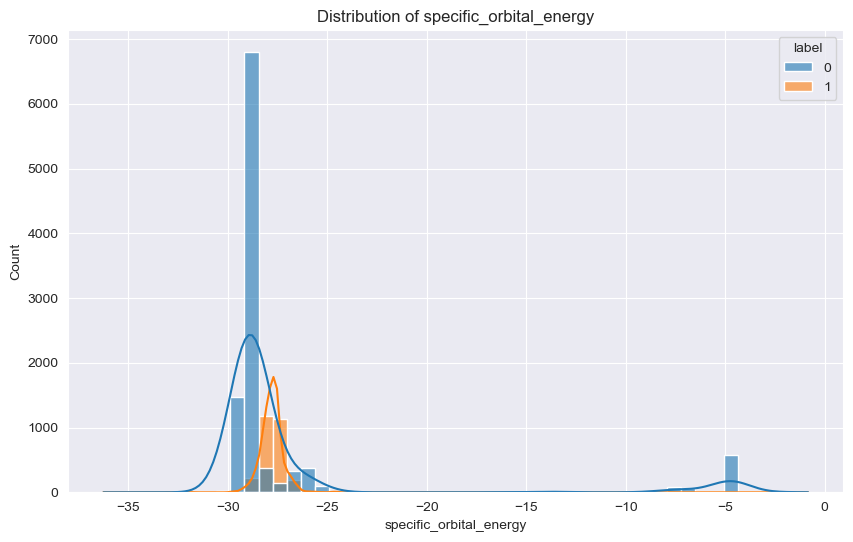

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='specific_orbital_energy', hue='label', kde=True, bins=50, alpha=0.6)
plt.title("Distribution of specific_orbital_energy")
plt.xlabel("specific_orbital_energy")
plt.show()

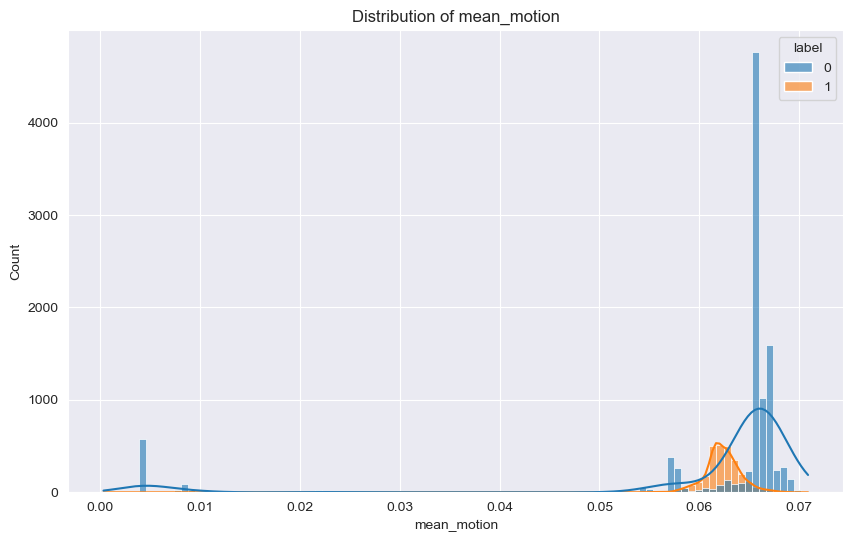

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='mean_motion', hue='label', kde=True, bins=100, alpha=0.6)
plt.title("Distribution of mean_motion")
plt.xlabel("mean_motion")
plt.show()

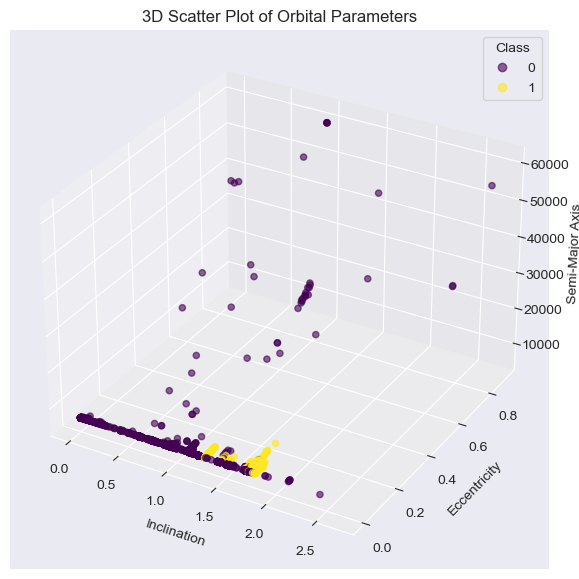

In [11]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['inclination'], df['eccentricity'], df['semi_major_axis'],
                     c=df['label'], cmap='viridis', alpha=0.6)
ax.set_xlabel('Inclination')
ax.set_ylabel('Eccentricity')
ax.set_zlabel('Semi-Major Axis')
plt.title("3D Scatter Plot of Orbital Parameters")
plt.legend(*scatter.legend_elements(), title="Class")
plt.show()

In [12]:
X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
#X_train_balanced, y_train_balanced = X_train, y_train

In [13]:
clf = RandomForestClassifier(n_estimators=100, random_state=42,oob_score=True)
clf.fit(X_train_balanced, y_train_balanced)

# Predictions and evaluation
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9836812144212523
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2072
           1       0.95      0.98      0.96       563

    accuracy                           0.98      2635
   macro avg       0.97      0.98      0.98      2635
weighted avg       0.98      0.98      0.98      2635



In [14]:
print("OOB Score:", clf.oob_score_)

OOB Score: 0.9907529722589168


In [15]:
train_scores = cross_val_score(clf, X_train, y_train, cv=5)
test_scores = cross_val_score(clf, X_test, y_test, cv=5)

# Calculate and print the mean scores
print("Mean Training Score:", np.mean(train_scores))
print("Mean Validation Score:", np.mean(test_scores))

Mean Training Score: 0.9861442251319132
Mean Validation Score: 0.9734345351043643


In [16]:
new_test_data, l = parse_tle_file(test_files[0], 1)
test_d_df = pd.DataFrame(new_test_data)
test_l = test_d_df['label']
test_d_df = test_d_df.drop(columns=['label'])
test_y = clf.predict(test_d_df)
print("Accuracy on the iri file:", accuracy_score(test_y, test_l))


Accuracy on the iri file: 0.9924242424242424


/var/folders/qd/v5ry5_cj447fbwhs1jj9bgqh0000gn/T/ipykernel_85567/1884770284.py:29: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  jd, fr = jday(datetime.utcnow().year, datetime.utcnow().month, datetime.utcnow().day,
/var/folders/qd/v5ry5_cj447fbwhs1jj9bgqh0000gn/T/ipykernel_85567/1884770284.py:30: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  datetime.utcnow().hour, datetime.utcnow().minute, datetime.utcnow().second)
